Implementation of Stein variational gradient descent (SVGD) in TensorFlow. And try to improve its performance in high-dimensional space.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as tfd

In [2]:
tf.reset_default_graph()

In [3]:
def expectation(f, xs, axis=0, name=None):
  """Expectation value of mapping function `f` to values `xs`.
  Args:
    f: Callable from tensor to tensor.
    xs: Tensor with the shape `[None]+fis`, where the `fis` is the
      shape of the input tensor of `f`.
  Returns:
    Tensor with the shape of the output tensor of `f`.
  """
  with tf.name_scope(name, 'Expectation', [xs]):
    fs = tf.map_fn(f, xs, parallel_iterations=100,
                   back_prop=False)
    return tf.reduce_mean(fs, axis)

def square_distance(x, y):
  return tf.reduce_sum(tf.square(x - y))

def rbf_kernel(x, y, h, name=None):
  """Implements the RBF kernel.
  Args:
    x: Tensor.
    y: Tensor with the same shape as the `x`.
    h: Non-vanishing scalar of float type.
  Returns:
    Scalar.
  """
  with tf.name_scope(name, 'RBFKernel', [x, y]):
    return tf.exp(-0.5/h * square_distance(x, y))

def grad_rbf_kernel(x, y, h, name=None):
  """Implements the gradients of the RBF kernel.
  Args:
    x: Tensor.
    y: Tensor with the same shape as the `x`.
    h: Non-vanishing scalar of float type.
  Returns:
    Tensor with the same shape as the `x`.
  """
  with tf.name_scope(name, 'RBFKernelGradient', [x, y]):
    return rbf_kernel(x, y, h) * (y - x) / h

def get_phi_star(samples, log_p, kernel, grad_kernel):
  """Get the function :math:`\phi_{\star}`(\cdot)` that maps
  from tensor of an arbitrary shape (say `x_shape`) to a tensor
  of the same shape.
  
  Args:
    samples: Tensor of the shape `[n_samples] + x_shape`.
    log_p: Callable that maps from tensor of `x_shape` to scalar.
    kernel: Callable that maps two tensors of `x_shape` to scaler.
    grad_kernel: The gradient of the `kernel`.
  Returns:
    Callable.
  """
  def phi_star(x):
    def adaptive_h():
      median_square = tf.reduce_mean(
          square_distance(tf.expand_dims(x, axis=0), samples))
      n_samples = samples.get_shape().as_list()[0]
      return median_square / tf.log(float(n_samples))
    def integrand(y):
      return (kernel(x, y, adaptive_h()) * tf.gradients(log_p(y), [y])[0]
              + grad_kernel(x, y, adaptive_h()))
    return expectation(integrand, samples)
  return phi_star

def median(value):
  value = tf.reshape(value, [-1])
  median_idx = value.get_shape().as_list()[0]//2
  return tf.nn.top_k(value, median_idx).values[median_idx-1]

In [4]:
def initialize_samples(n_samples, n_dims):
  samples_shape = [n_samples, n_dims]
  initializer = tf.initializers.random_uniform(minval=-1, maxval=1)
  samples = tf.get_variable(
      'samples', shape=samples_shape,
      dtype='float32', initializer=initializer)
  return samples

n_samples = 200
n_dims = 1
xs = initialize_samples(n_samples, n_dims)

In [5]:
dist = tfd.MultivariateNormalDiag(tf.zeros([n_dims]),
                                  tf.ones([n_dims]))
log_p = dist.log_prob

In [6]:
phi_star = get_phi_star(xs, log_p, rbf_kernel, grad_rbf_kernel)

In [7]:
class AdaGrad(object):
  def __init__(self, xs, phi_star, learning_rate, alpha=0.9):
    self.xs = xs
    self.phi_star = phi_star
    self.learning_rate = learning_rate
    self.alpha = alpha
    self.cache = tf.Variable(tf.zeros(shape=xs.get_shape(),
                                      dtype='float32'),
                             name='AdaGradCache')
  
  def update(self):
    raw_grads = tf.map_fn(self.phi_star, self.xs, name='Gradients')
    new_cache = (self.alpha * self.cache
                 + (1 - self.alpha) * tf.square(raw_grads))
    update_cache_op = tf.assign(self.cache, new_cache, name='UpdateCache')
    with tf.control_dependencies([update_cache_op]):
      adjusted_grads = raw_grads / (tf.sqrt(self.cache) + 1e-8)
      delta_xs = self.learning_rate * adjusted_grads
      update_op = tf.assign(self.xs, self.xs + delta_xs, name='UpdateVars')
      return update_op
    
update_op = AdaGrad(xs, phi_star, learning_rate=0.1).update()

In [8]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

After step 0


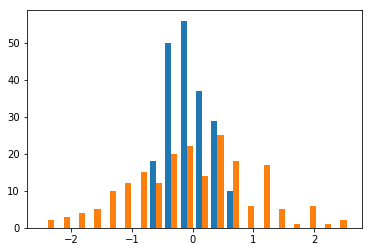

After step 1


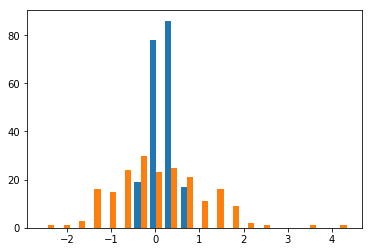

After step 2


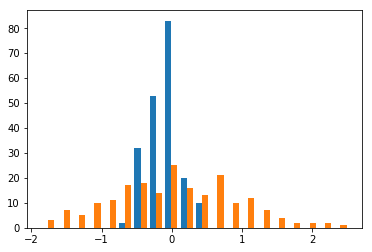

After step 3


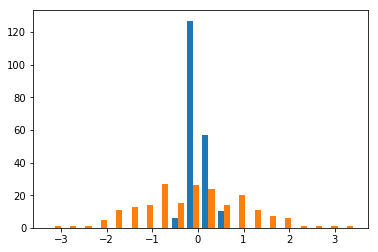

After step 4


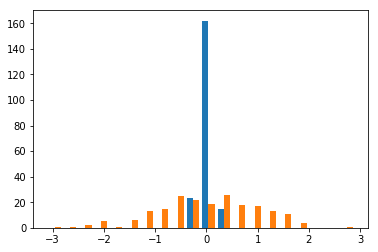

After step 5


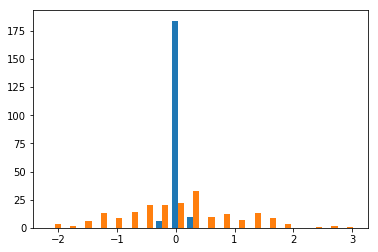

After step 6


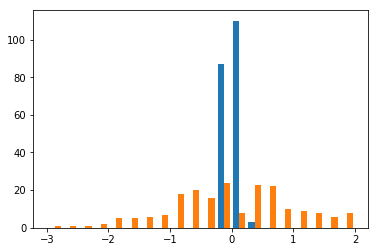

After step 7


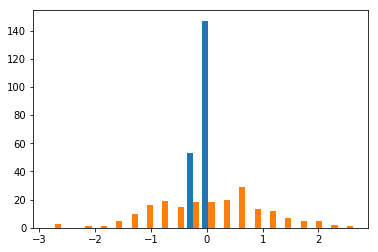

After step 8


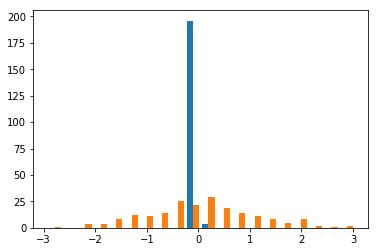

After step 9


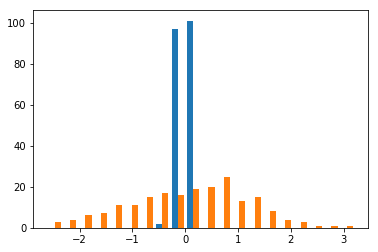

After step 10


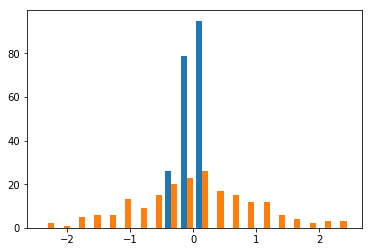

After step 11


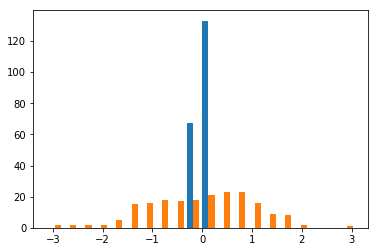

After step 12


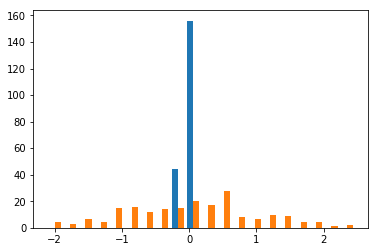

After step 13


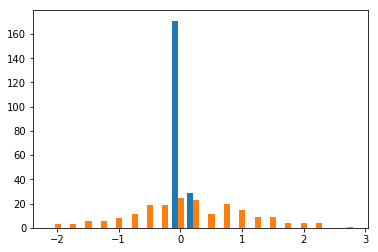

After step 14


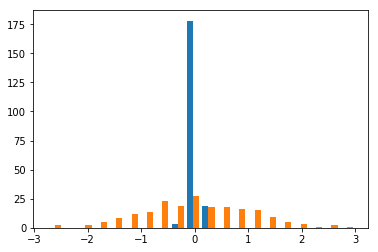

After step 15


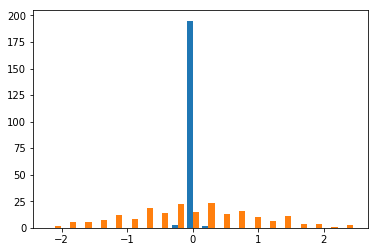

After step 16


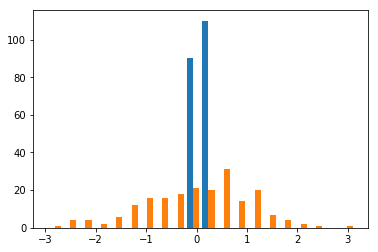

After step 17


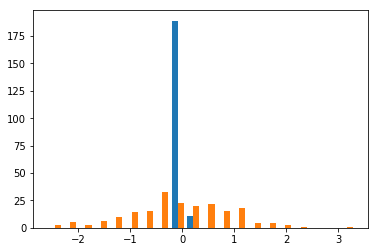

After step 18


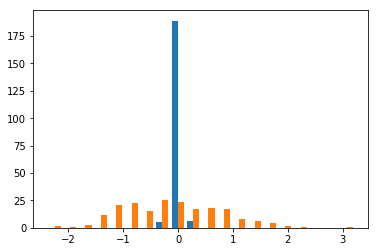

After step 19


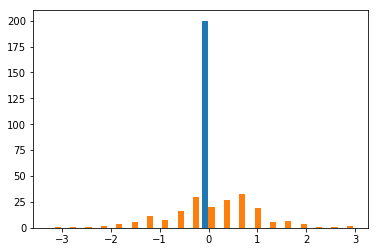

After step 20


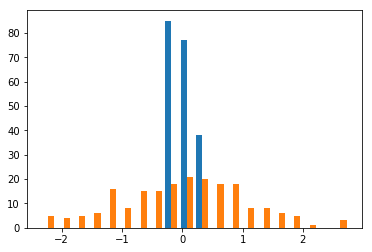

After step 21


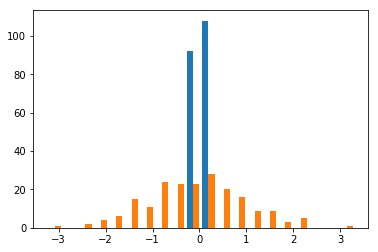

After step 22


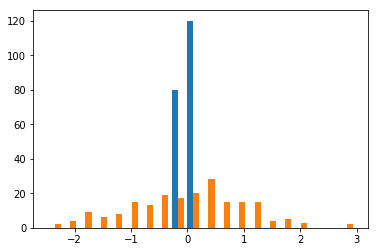

After step 23


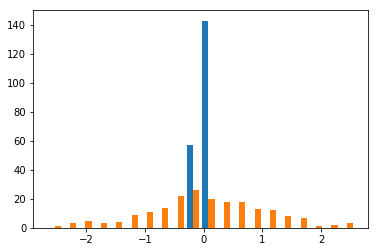

After step 24


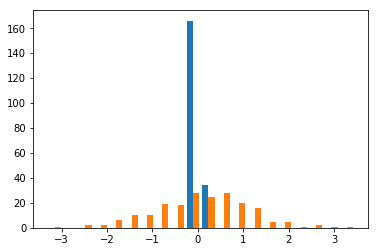

After step 25


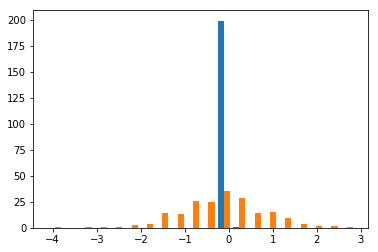

After step 26


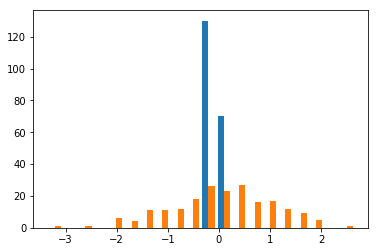

After step 27


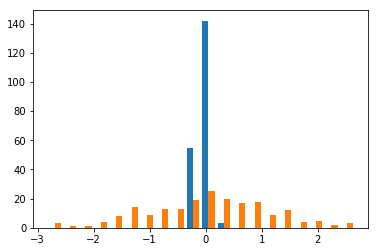

After step 28


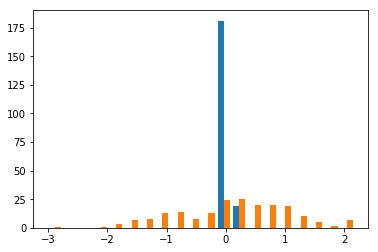

After step 29


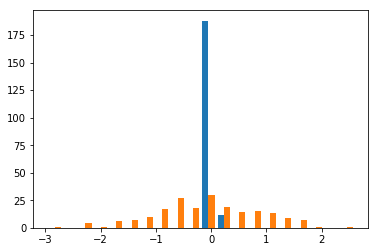

After step 30


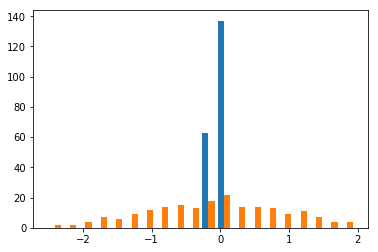

After step 31


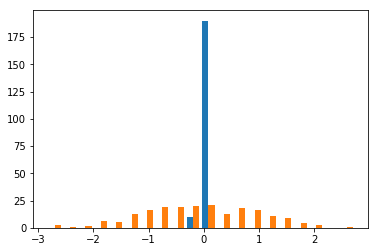

After step 32


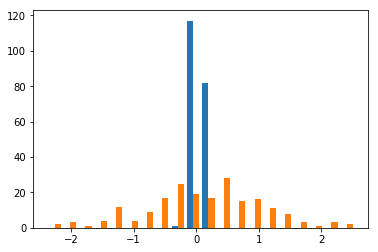

After step 33


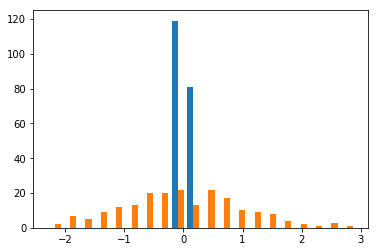

After step 34


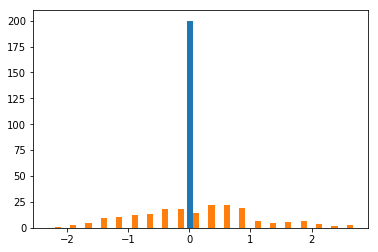

After step 35


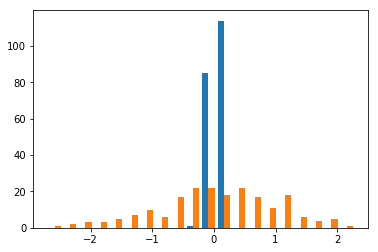

After step 36


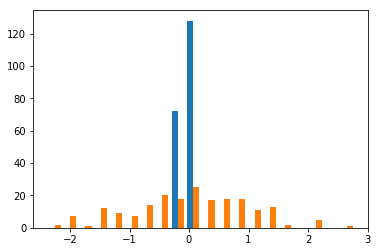

After step 37


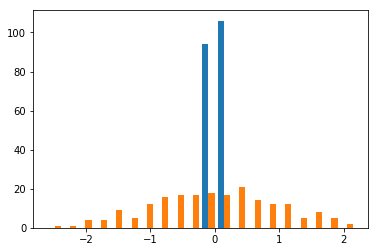

After step 38


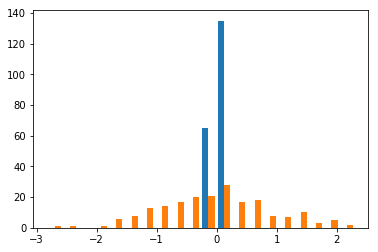

After step 39


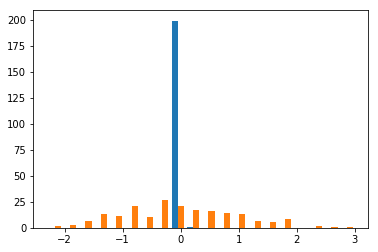

After step 40


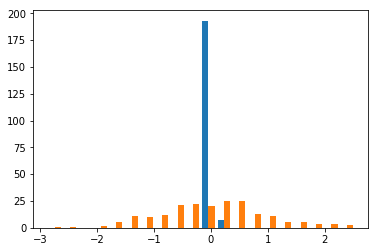

After step 41


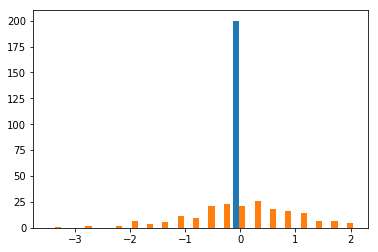

After step 42


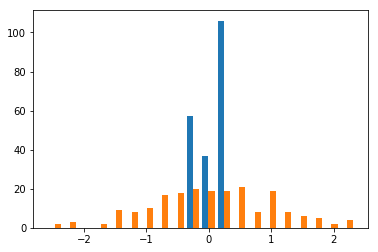

After step 43


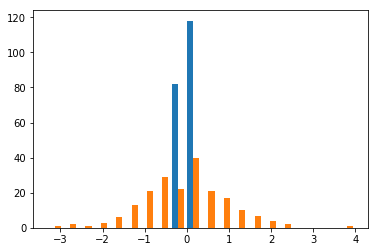

After step 44


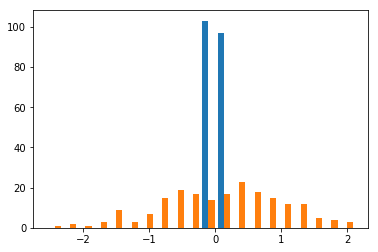

After step 45


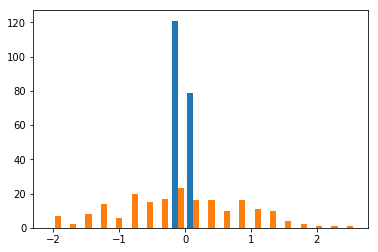

After step 46


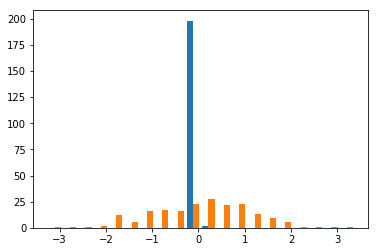

After step 47


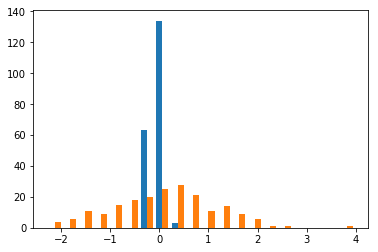

After step 48


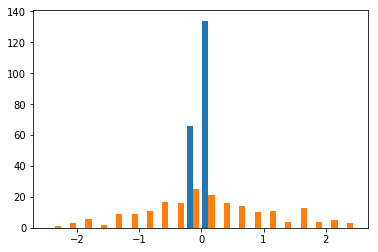

After step 49


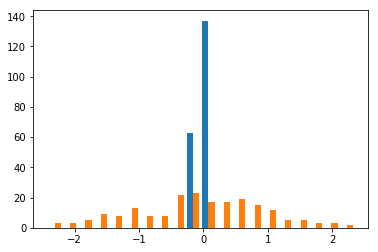

After step 50


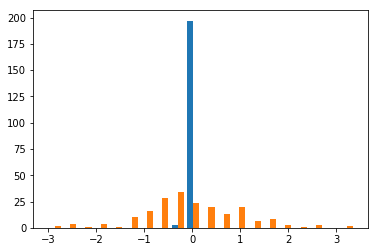

After step 51


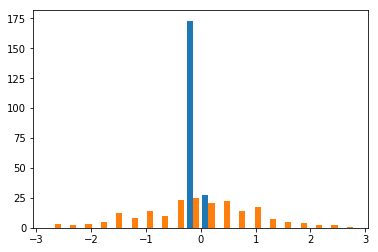

After step 52


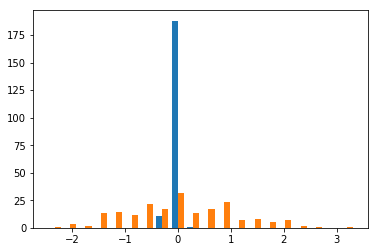

After step 53


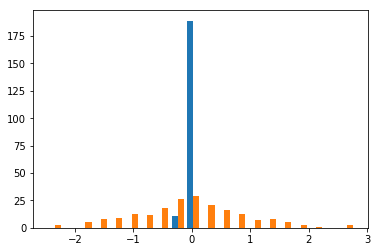

After step 54


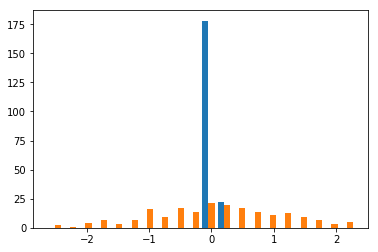

After step 55


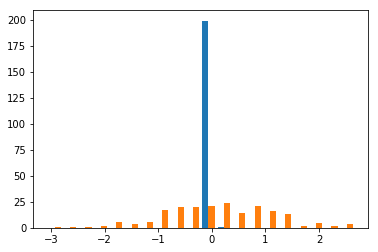

After step 56


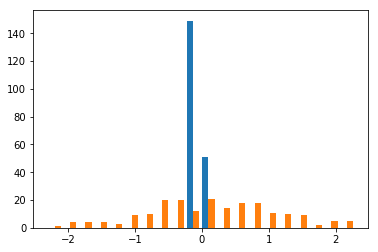

After step 57


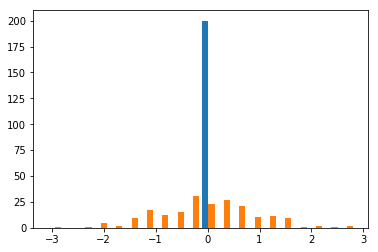

After step 58


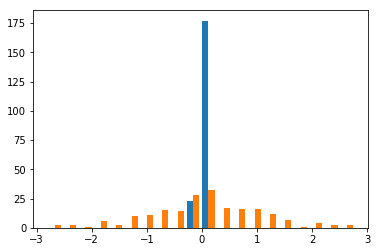

After step 59


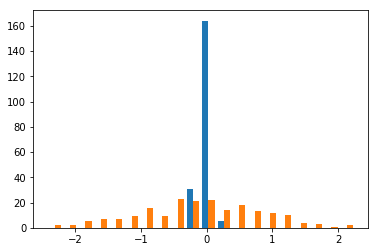

After step 60


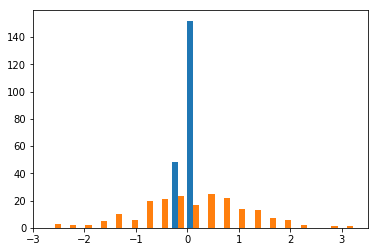

After step 61


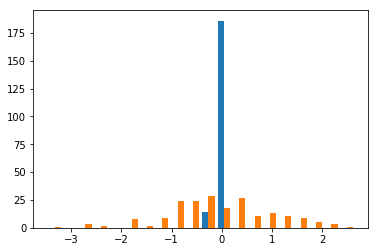

After step 62


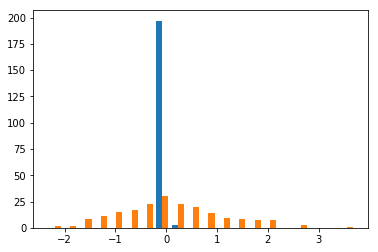

After step 63


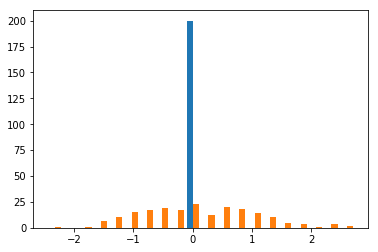

After step 64


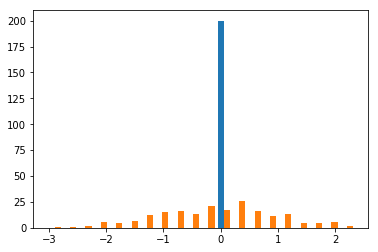

After step 65


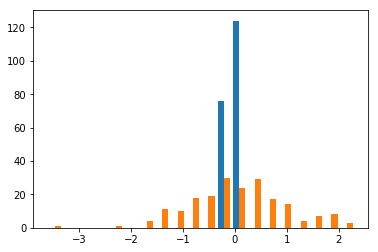

After step 66


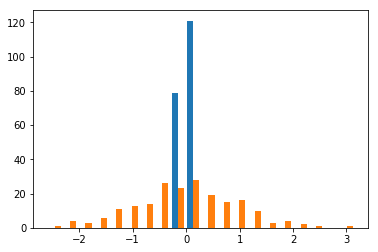

After step 67


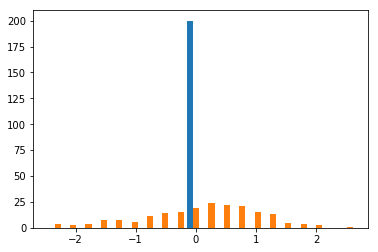

After step 68


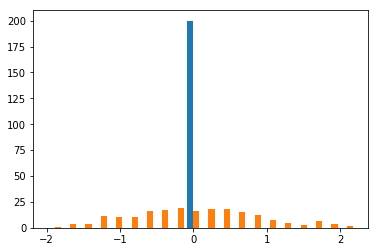

After step 69


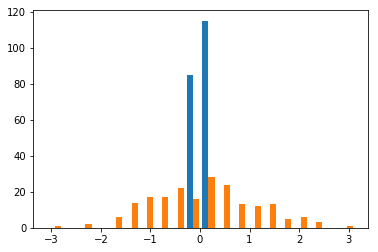

After step 70


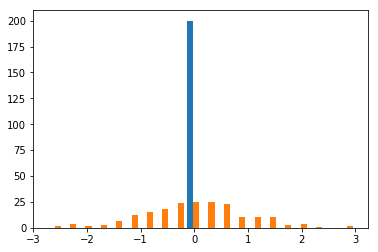

After step 71


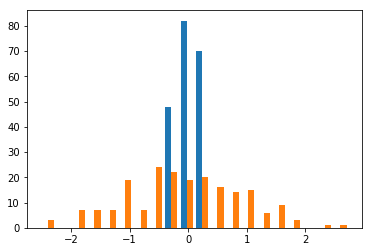

After step 72


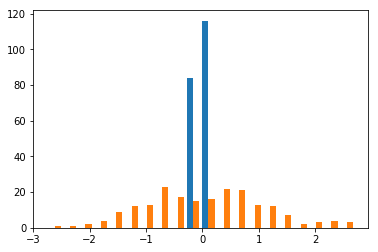

After step 73


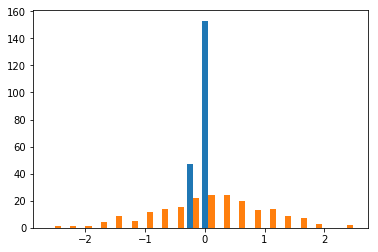

After step 74


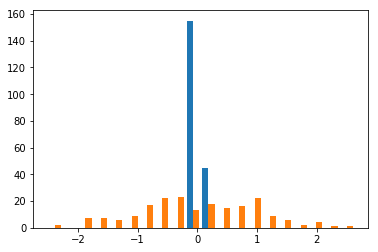

After step 75


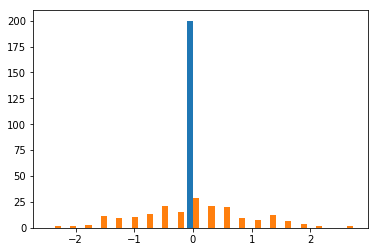

After step 76


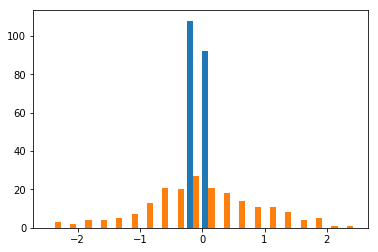

After step 77


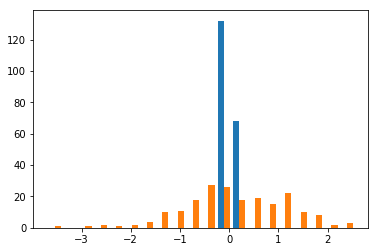

After step 78


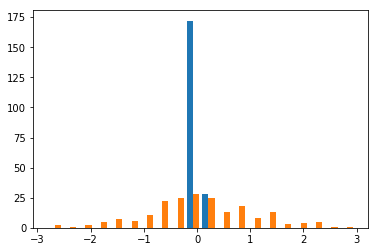

After step 79


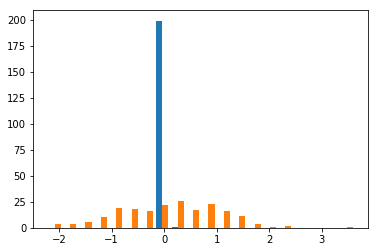

After step 80


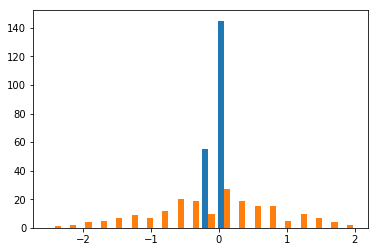

After step 81


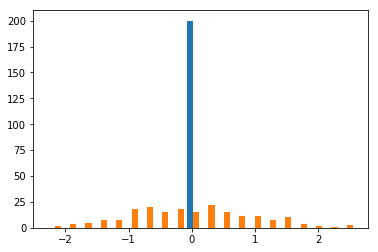

After step 82


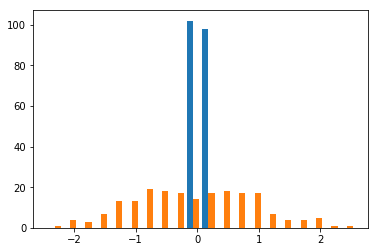

After step 83


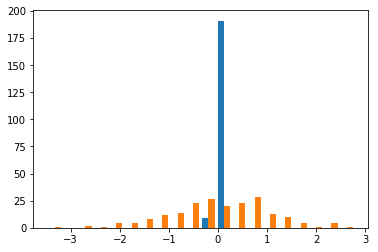

After step 84


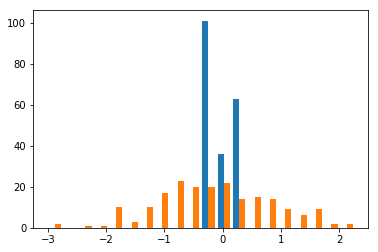

After step 85


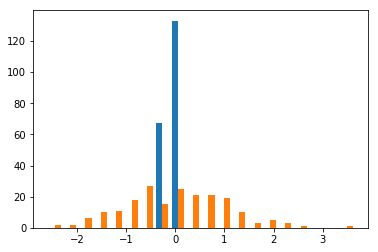

After step 86


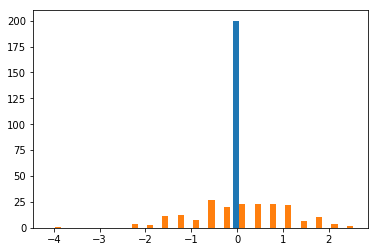

After step 87


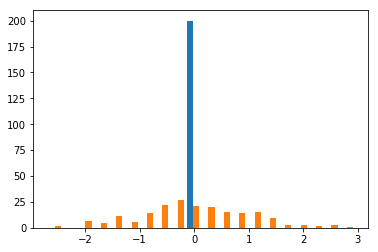

After step 88


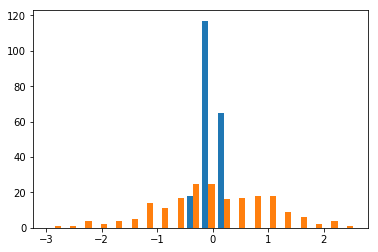

After step 89


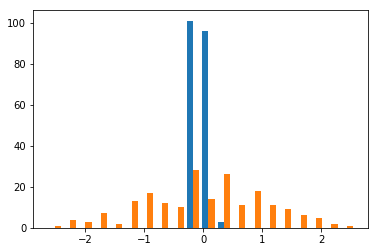

After step 90


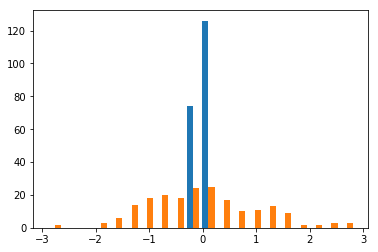

After step 91


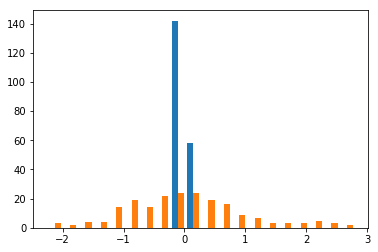

After step 92


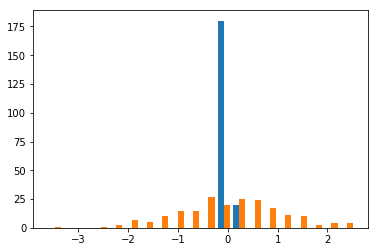

After step 93


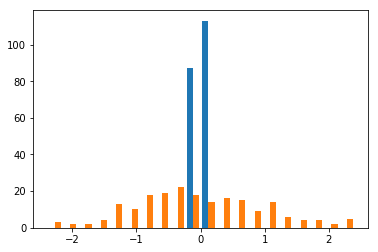

After step 94


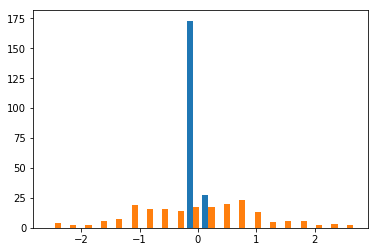

After step 95


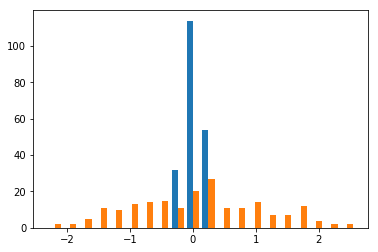

After step 96


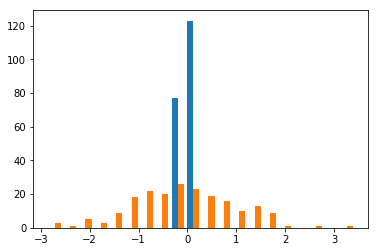

After step 97


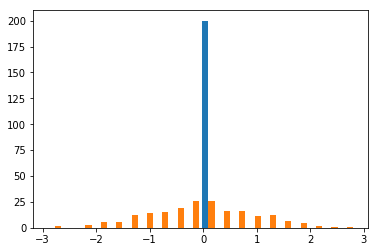

After step 98


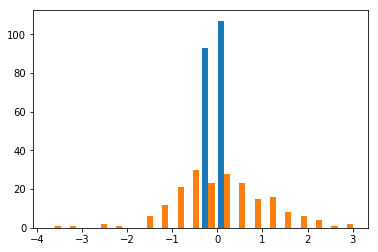

After step 99


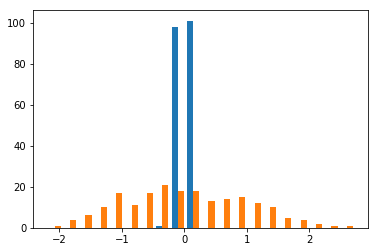

CPU times: user 49min 16s, sys: 2min 38s, total: 51min 55s
Wall time: 23min 57s


In [9]:
%%time

n_iters = 100
for step in range(n_iters):
    sess.run(update_op)
    if step % 1 == 0:
        print('After step {}'.format(step))
        axis=0
        xs_val = sess.run(xs)
        targets = np.random.normal(size=n_samples)
        plt.hist([xs_val[:,axis], targets], bins=20)
        plt.show()
xs_val = sess.run(xs)

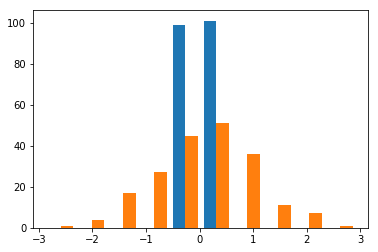

In [10]:
axis=0
targets = np.random.normal(size=n_samples)
plt.hist([xs_val[:,axis], targets], bins=10)
plt.show()